In [ ]:
# pip install googletrans==4.0.0-rc1 specifically
# pip install the rest below
# the two csv files mentioned/used below should be in the data/ folder of the drive

In [ ]:
import pandas as pd
import numpy as np
import sklearn.feature_extraction
import matplotlib.pyplot as plt

# Preprocess Lyrics

In [ ]:
df = pd.read_csv("lyrics/all_lyrics.csv")

df

,Unnamed: 0,country,artist,title,lyrics
0,0,United States,The Weeknd,Blinding Lights,234 ContributorsTranslationsTürkçeSvenskaEspañ...
1,1,United Kingdom,The Killers,Mr. Brightside,231 ContributorsTranslationsFrançaisDeutschMr....
2,2,Andorra,Luis Fonsi,Despacito (Featuring Daddy Yankee),437 ContributorsTranslationsNederlandsไทย / Ph...
3,3,Argentina,Manuel Turizo,La Bachata,10 ContributorsTranslationsEnglishDeutschLa Ba...
4,4,Australia,Glass Animals,Heat Waves,161 ContributorsTranslationsItalianoDeutschFra...
...,...,...,...,...,...
71,71,Ukraine,SadSvit,Силуети,9 ContributorsСилуети (Silhouettes) Lyrics\n\n...
72,72,United Arab Emirates,The Kid LAROI,Stay,136 ContributorsTranslationsTürkçeEspañolPortu...
73,73,Uruguay,Manuel Turizo,La Bachata,10 ContributorsTranslationsEnglishDeutschLa Ba...
74,74,Venezuela,Bad Bunny,Me Porto Bonito,33 ContributorsTranslationsEnglishDeutschFranç...


In [ ]:
# Translate all songs that aren't in English
# (might have to run it a couple times for it to work)

from googletrans import Translator

def translate_text(input_text, target_language='en'):
    translator = Translator()
    translated_text = translator.translate(input_text, dest=target_language)
    return translated_text.text

df['lyrics'] = df['lyrics'].map(translate_text)

In [ ]:
lyrics = {} # maps country to their lyrics (represented as a list of sentences)

for index, row in df.iterrows():
    lyrics[row['country']] = row['lyrics'].split('\n')

{'United States': ['234 ContributorsTranslationsTürkçeSvenskaEspañolSlovenčinaРусскийPortuguêsPolskiNorsk (bokmål / riksmål)日本語ItalianoHebrewDeutschFrançaisفارسیNederlandsDanskShqipالعربيةBlinding Lights Lyrics',
  'Yeah',
  '',
  "I've been tryna call",
  "I've been on my own for long enough",
  'Maybe you can show me\u2005how\u2005to love, maybe',
  "I'm\u2005goin' through withdrawals",
  "You don't even have\u2005to do too much",
  'You can turn me on with just a touch, baby',
  '',
  'I look around and',
  "Sin City's cold and empty (Oh)",
  "No one's around to judge me (Oh)",
  "I can't see clearly when you're gone",
  '',
  "I said, ooh, I'm blinded by the lights",
  "No, I can't sleep until I feel your touch",
  "I said, ooh, I'm drowning in the night",
  "Oh, when I'm like this, you're the one I trust",
  'Hey, hey, hey',
  '',
  "I'm running out of time",
  "'Cause I can see the sun light up the sky",
  'So I hit the road in overdrive, baby, oh',
  'You might also like',
  "Th

In [ ]:
# remove all translation credit lines at the top of each lyrics
numbers = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

for country in lyrics:
    first_line = lyrics[country][0]
    for num in numbers:
        if num in first_line:
            lyrics[country].pop(0)
            break

In [ ]:
# remove empty lines from songs
for country in lyrics:
    temp = []
    for sentence in lyrics[country]:
        if sentence != "":
            temp.append(sentence)

    lyrics[country] = temp

# Run BERT emotions model

In [ ]:
from transformers import BertTokenizer
from model import BertForMultiLabelClassification

/Users/ziyanwu/Desktop/6.S079/project/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Tokenizer and BERT models
# Source: https://github.com/monologg/GoEmotions-pytorch/tree/master

tokenizer = BertTokenizer.from_pretrained("monologg/bert-base-cased-goemotions-original")
model = BertForMultiLabelClassification.from_pretrained("monologg/bert-base-cased-goemotions-original")

/Users/ziyanwu/Desktop/6.S079/project/venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
# labels

id2label = ["admiration", "amusement", "anger", "annoyance", "approval", "caring", "confusion", "curiosity", "desire", "disappointment", "disapproval", "disgust", "embarrasment", "excitement", "fear", "gratitude", "grief", "joy", "love", "nervousness", "optimism", "pride", "realization", "relief", "remorse", "sadness", "surprise", "neutral"]
label2id = {}
for i, label in enumerate(id2label):
    label2id[label] = i

In [ ]:
emotions = {} # maps countries to the emotions of their sentences (can be more than one emotion per sentence)
threshold = 0.3

for country in lyrics:
    temp = []
    for sentence in lyrics[country]:
        tokenized_input = tokenizer(sentence, return_tensors='pt')
        outputs = model(**tokenized_input)[0].detach().numpy()


        scores = 1 / (1 + np.exp(-outputs))  # Sigmoid
        results = []

        for item in scores:
            labels = []
            scores = []
            for idx, s in enumerate(item):
                if s > threshold:
                    labels.append(id2label[idx])
                    scores.append(s)
            results.append({"labels": labels, "scores": scores})

        temp.append(results[0])

    emotions[country] = temp


In [ ]:
normalized_country_vectors = {}

for country in emotions:
    temp = [0] * len(id2label)
    for sentence in emotions[country]:
        for emotion in sentence["labels"]:
            temp[label2id[emotion]] += 1

    temp = np.array(temp)

    # normalize
    temp = temp / len(emotions[country])

    normalized_country_vectors[country] = temp

In [ ]:
for c in normalized_country_vectors:
    print(f"{c}: {normalized_country_vectors[c]}")

United States: [0.         0.         0.         0.         0.02777778 0.05555556
 0.02777778 0.         0.         0.08333333 0.11111111 0.
 0.         0.08333333 0.         0.         0.         0.02777778
 0.02777778 0.         0.02777778 0.         0.08333333 0.
 0.         0.02777778 0.05555556 0.72222222]
United Kingdom: [0.         0.         0.         0.04255319 0.         0.
 0.         0.04255319 0.04255319 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.0212766  0.         0.         0.
 0.         0.08510638 0.         0.87234043]
Andorra: [0.         0.         0.         0.         0.03658537 0.03658537
 0.01219512 0.         0.09756098 0.         0.         0.
 0.         0.02439024 0.         0.01219512 0.         0.01219512
 0.07317073 0.         0.         0.         0.02439024 0.
 0.         0.         0.07317073 0.75609756]
Argentina: [0.         0.         0.03030303 0.24242424 0.         0.12121212
 0.0

# Plots

In [ ]:
gdp_df = pd.read_csv("gdp_per_capita.csv")

gdp_df

,Country,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029
0,Afghanistan,no data,no data,no data,no data,no data,no data,no data,no data,no data,...,611.268,423.993,422.229,no data,no data,no data,no data,no data,no data,no data
1,Albania,728.359,817.734,824.542,815.529,788.332,788.801,855.724,832.245,805.046,...,5278.986,6259.762,6657.637,7956.559,8924.317,9474.065,10135.055,10827.923,11578.584,12389.74
2,Algeria,2462.085,2502.13,2446.588,2514.256,2640.191,2988.545,2929.092,2935.816,2326.571,...,3757.585,4169.984,4981.822,5323.635,5721.678,5869.435,5998.622,6073.858,6129.969,6170.756
3,Andorra,no data,no data,no data,no data,no data,no data,no data,no data,no data,...,36973.845,41806.876,41378.881,43784.571,44899.596,45570.14,46093.258,46597.511,47098.423,47563.642
4,Angola,802.627,731.427,712.576,723.654,747.325,817.068,743.735,828.958,875.526,...,1709.283,2169.648,3439.391,2565.912,2431.58,2444.365,2455.711,2528.702,2571.26,2617.815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,Major advanced economies (G7),11275.803,11554.398,11436.111,12005.038,12568.159,13252.936,15946.884,18227.138,20367.02,...,50839.174,55977.766,57110.146,60221.173,62412.739,64658.942,67067.991,69485.17,72050.992,74590.436
224,Middle East and Central Asia,2108.544,2179.306,2101.667,2075.924,2039.69,2041.836,2023.437,2329.576,2385.981,...,4090.533,4721.043,5542.042,5582.4,5744.87,5887.207,6124.102,6384.882,6637.653,6908.869
225,Other advanced economies,6888.89,6933.195,6795.563,6702.399,6951.035,6864.222,8294.847,10109.366,11791.237,...,42672.028,49582.899,49454.631,49696.398,51506.626,53692.239,55812.83,57915.546,60155.29,62416.984
226,Sub-Saharan Africa,no data,no data,no data,no data,no data,no data,no data,no data,no data,...,1585.038,1744.896,1808.8,1699.109,1620.972,1674.716,1736.191,1810.386,1888.088,1971.149


In [ ]:
# Map countries to their gdp data for a specific year (2023 in this case)

gdp_name_map = {
    "Russia": "Russian Federation",
    "Hong Kong": "Hong Kong SAR",
    "Saudi": "Saudi Arabia",
    "Slovakia": "Slovak Republic",
    "South Korea": "Korea, Republic of",
    "Taiwan": "Taiwan Province of China",
    "Turkey": "Türkiye, Republic of",
}

# gdp_reverse_name_map = {}
# for country in gdp_name_map:
#     gdp_reverse_name_map[gdp_name_map[country]] = country

gdp_map = {} # maps countries to gdp
for country in normalized_country_vectors:
    orig_name = country
    if country in gdp_name_map:
        country = gdp_name_map[country]

    gdp = list(gdp_df.loc[gdp_df["Country"] == country, "2023"])[0]

    gdp_map[orig_name] = gdp

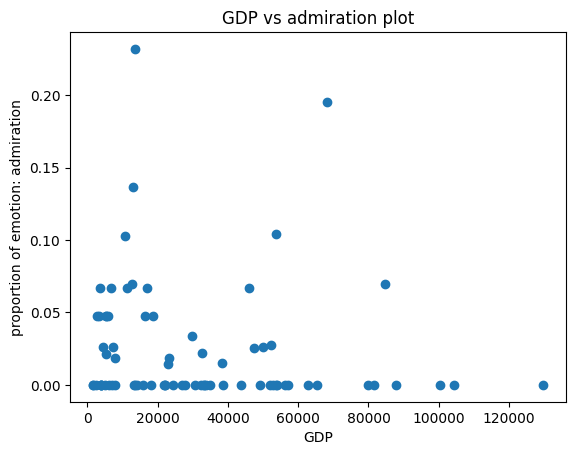

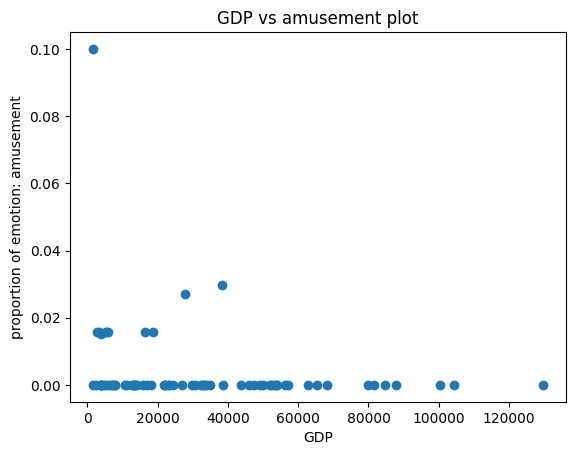

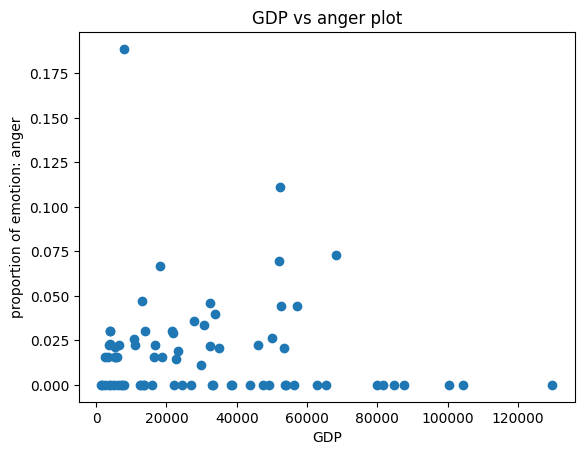

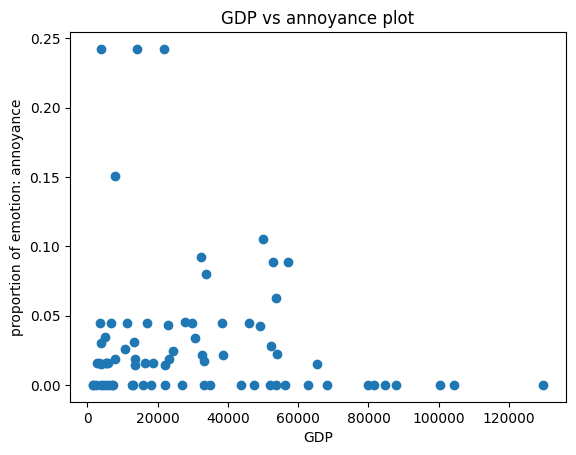

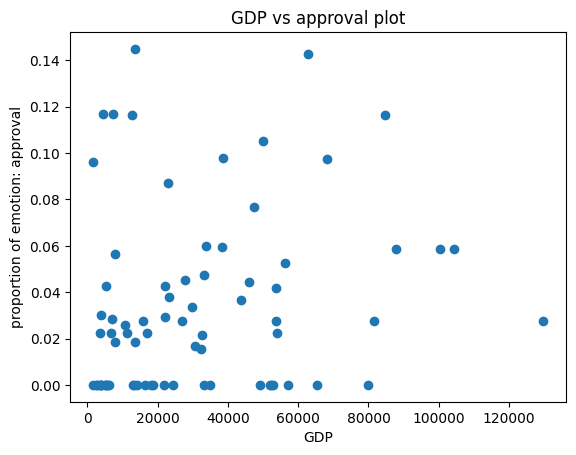

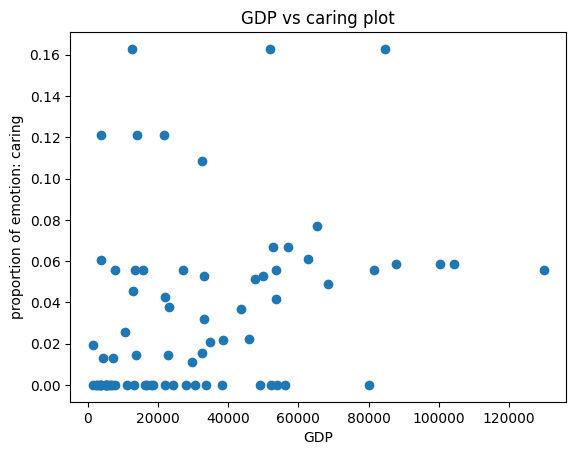

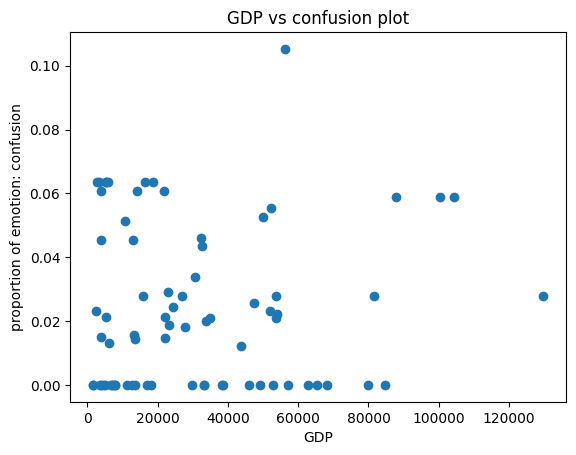

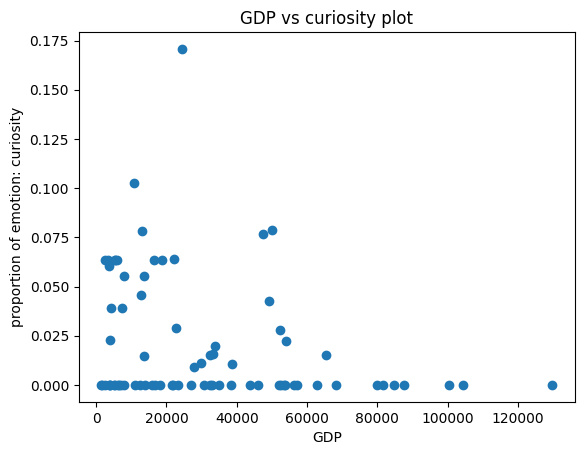

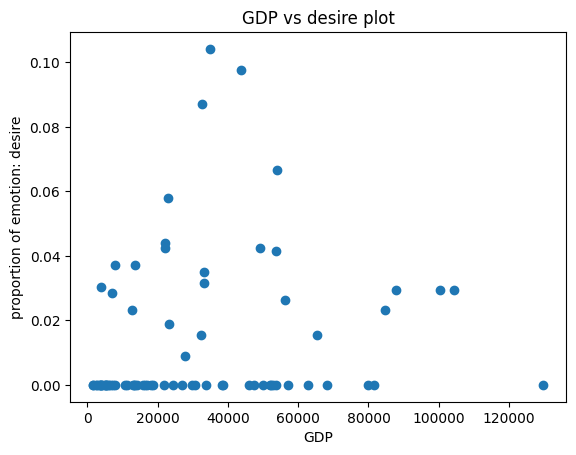

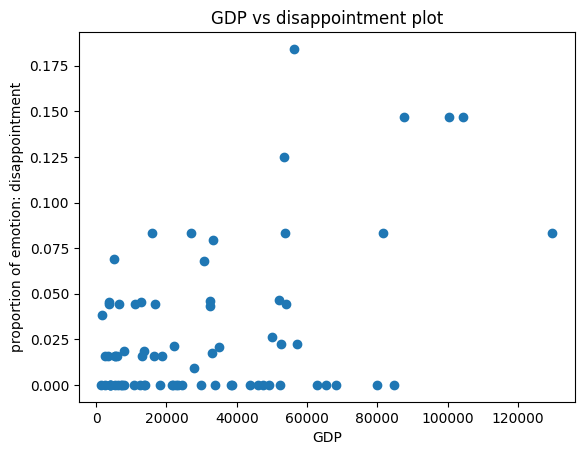

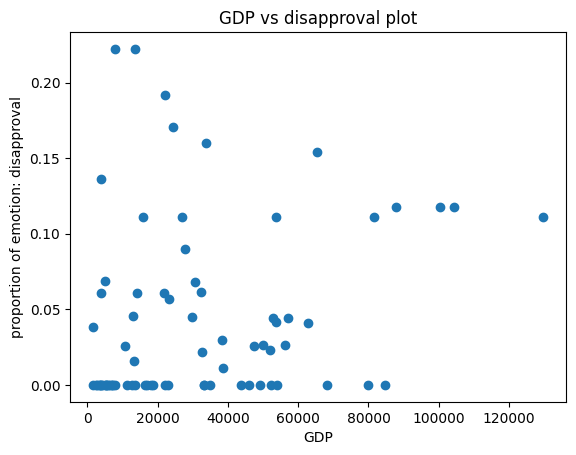

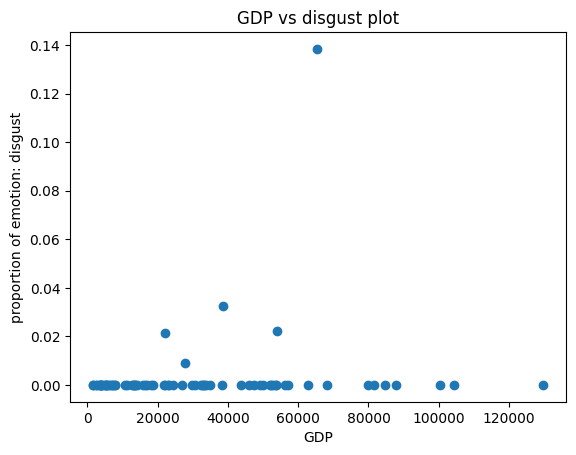

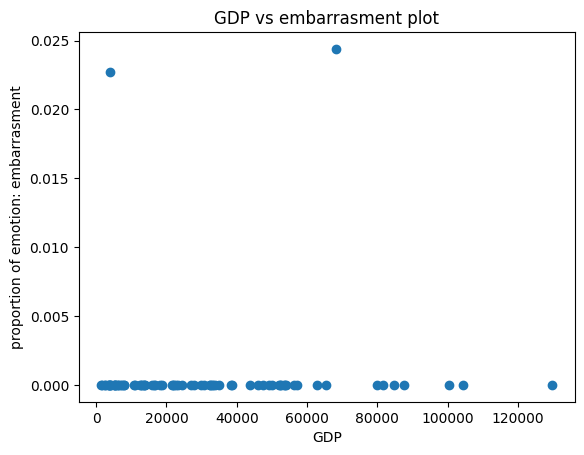

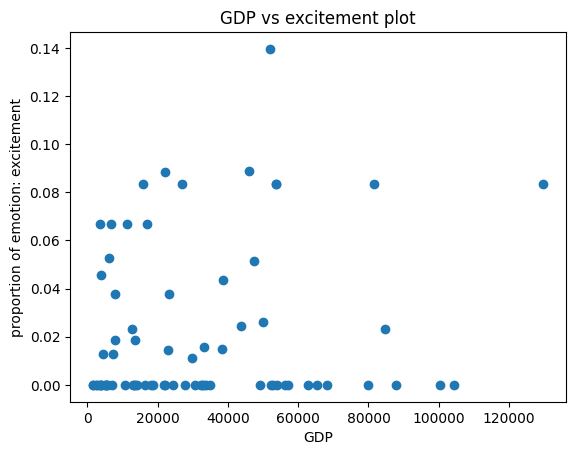

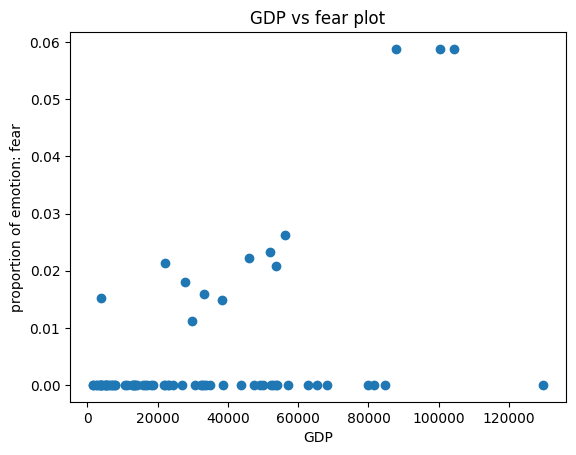

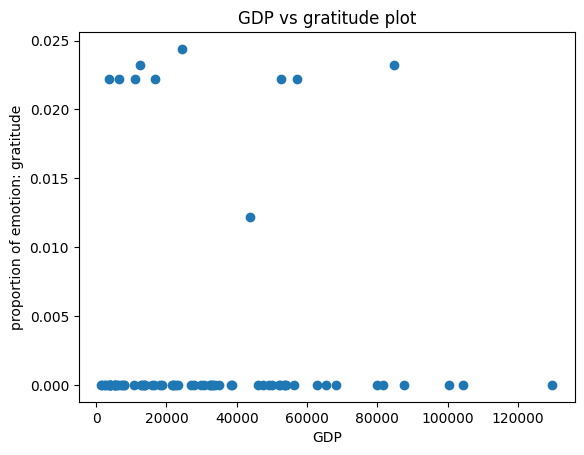

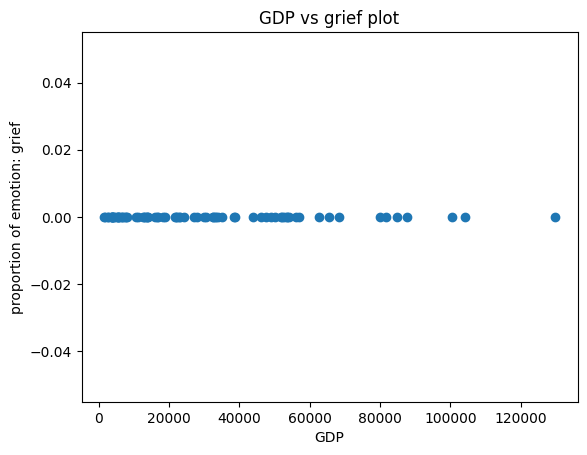

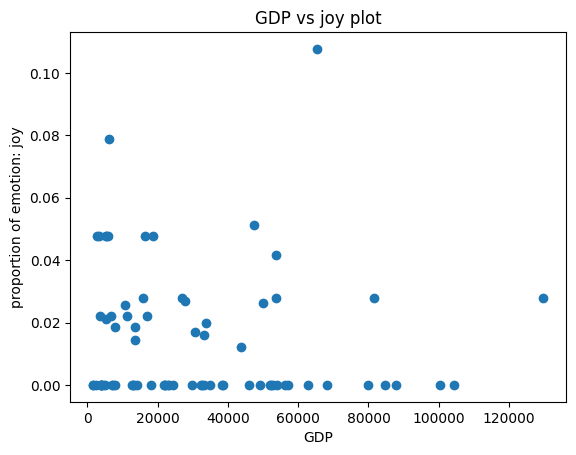

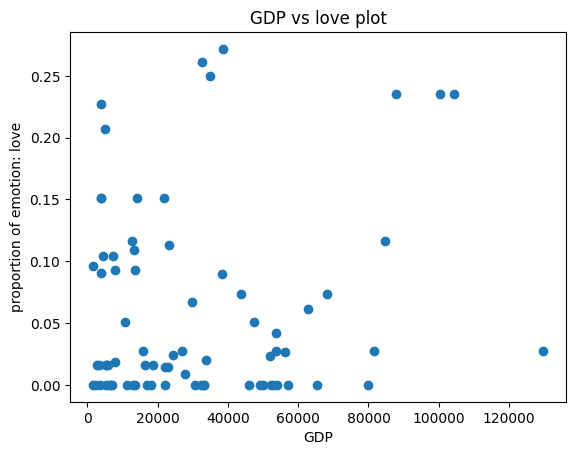

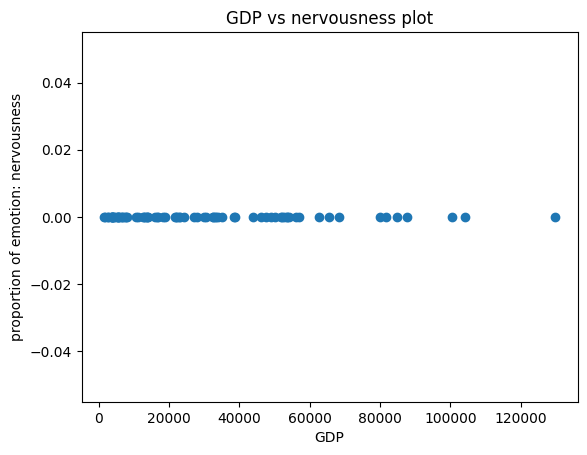

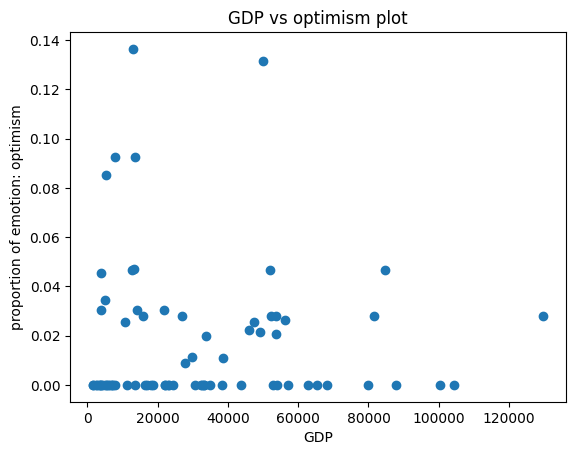

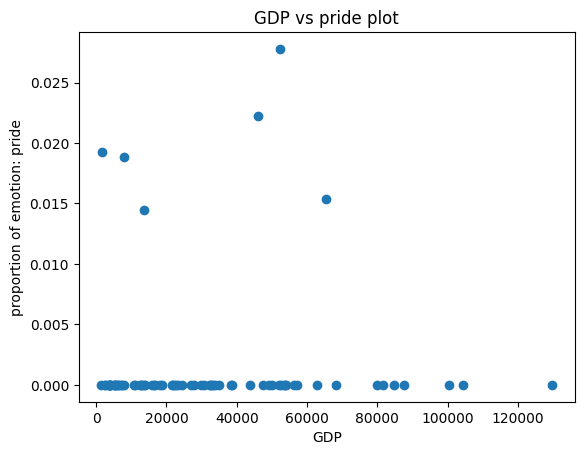

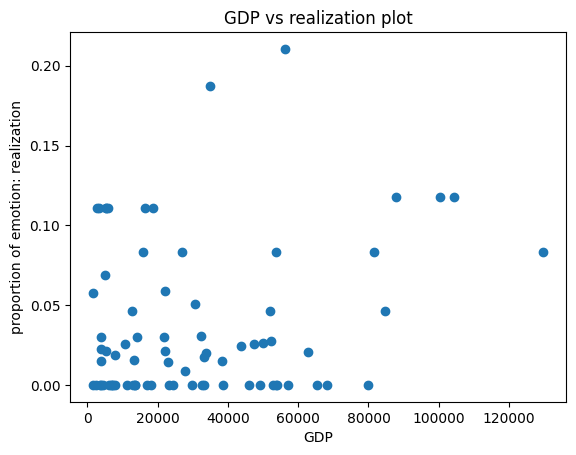

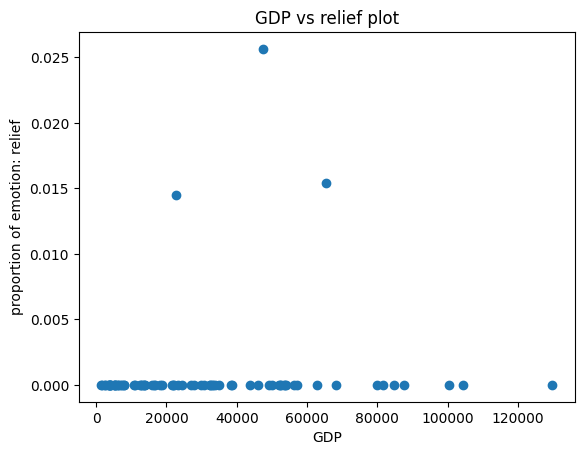

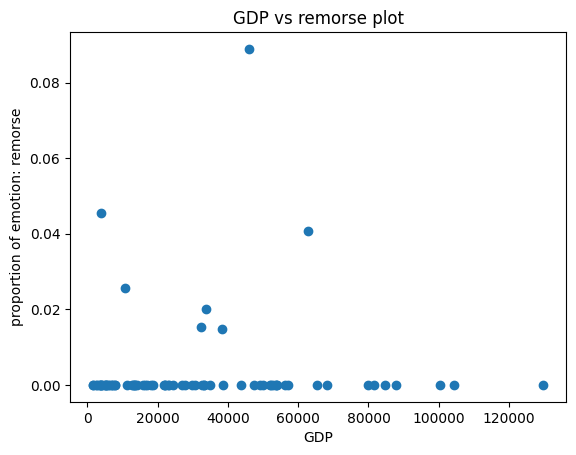

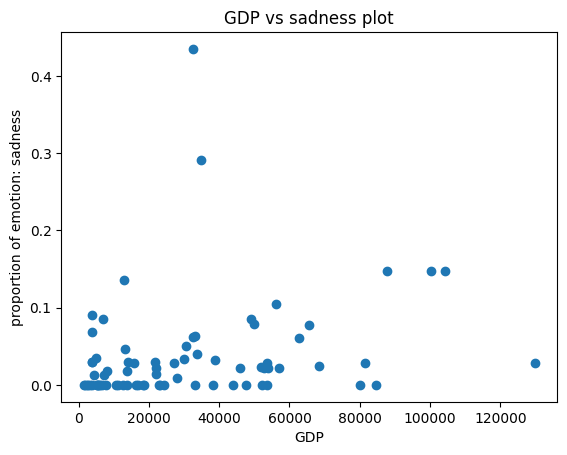

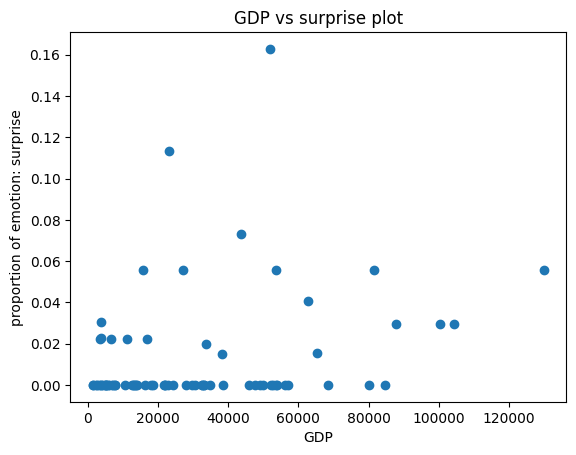

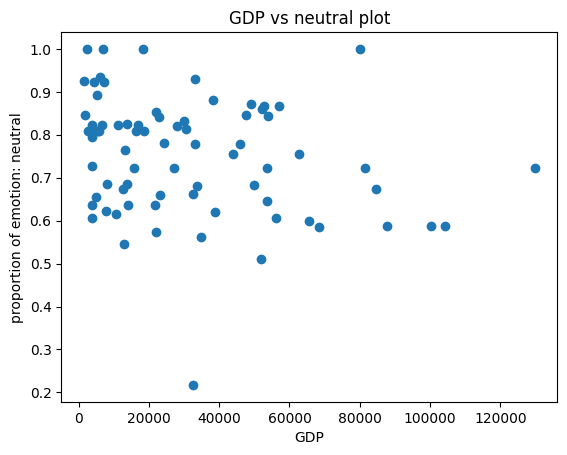

In [ ]:
# map scatter plot of proportion of emotion vs gdp for each emotion

for i, emotion in enumerate(id2label):
    x = [] # gdp data
    y = [] # proportion of emotion

    for country in normalized_country_vectors:
        x.append(float(gdp_map[country]))
        y.append(normalized_country_vectors[country][i])


    plt.scatter(x, y)
    plt.title(f"GDP vs {emotion} plot")
    plt.xlabel("GDP")
    plt.ylabel(f"proportion of emotion: {emotion}")

    plt.savefig(f"plots/gdp_emotions/{emotion}.png")
    plt.show()


In [ ]:
# Get deterministic ordering for countries

country_order = sorted(list(normalized_country_vectors.keys()))

vectors = []
for i, country in enumerate(country_order):
    vectors.append(normalized_country_vectors[country])

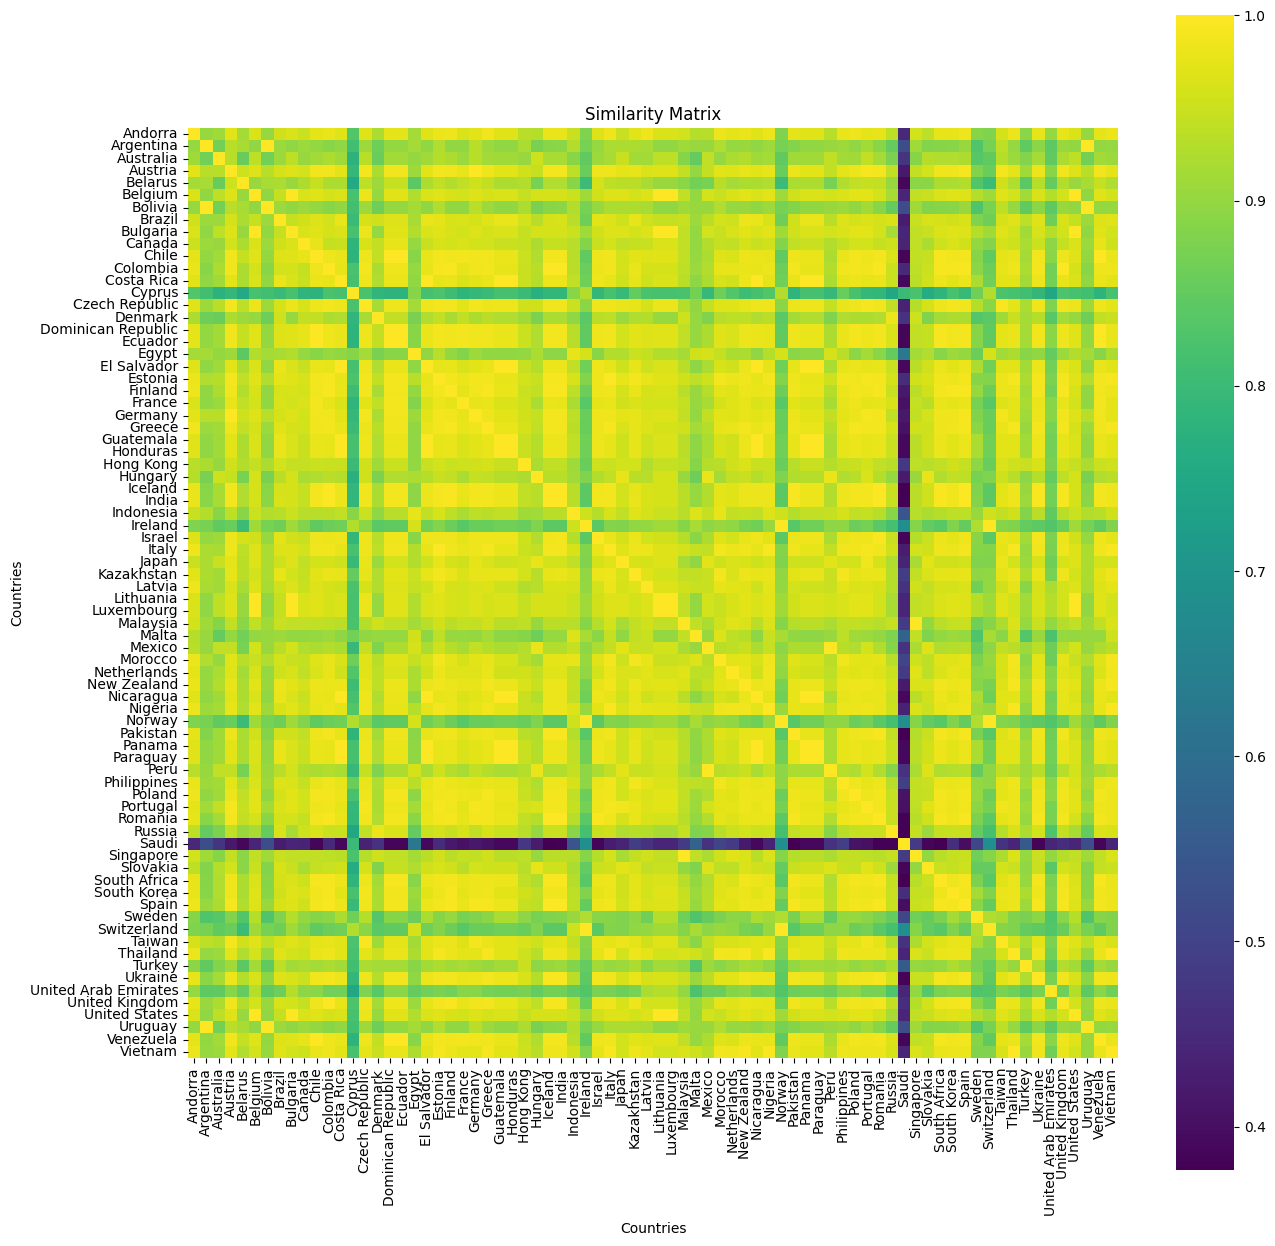

In [ ]:
# Plot similarity heatmap

from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

matrix = cosine_similarity(vectors)

plt.figure(figsize=(15, 15))
sns.heatmap(matrix, cmap='viridis', square=True, xticklabels=country_order, yticklabels=country_order)
plt.xlabel('Countries')
plt.ylabel('Countries')
plt.title('Similarity Matrix')

plt.savefig("plots/similarity_heatmap.png")
plt.show()